### Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import pandas as pd

### Load and Process the data

In [2]:
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Generator model

In [3]:
from tensorflow.keras import layers, models

def make_generator_model():
    model = models.Sequential([
        layers.Dense(4 * 4 * 512, use_bias=False, input_dim=100),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, 512)), 

        # First Layer
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Second Layer
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Third Layer
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        # Output Layer
        layers.Conv2DTranspose(3, (3, 3), padding='same', use_bias=False, activation='tanh'),
    ])
    return model



### Discriminator model

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid') 
    ])
    return model

### Loss functions

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

In [6]:
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Function to store Images

In [7]:
# Generate and save images
def saveImages(model, epoch, test_input, saveImages_path):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5, 5))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i + 1)
        image = (predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.imshow(image)
        plt.axis('off')
    plt.savefig(os.path.join(saveImages_path, f'saved_at_epoch_{epoch:04d}.png'))
    plt.show()
    plt.close()

### Function to plot Losses

In [8]:
def loss_plot(gen_losses, disc_losses, epochs, run_path):
    losses_df = pd.DataFrame({
        'epoch': range(1, epochs + 1),
        'gen_loss': gen_losses,
        'disc_loss': disc_losses
    })
    losses_df.to_csv(os.path.join(run_path, 'losses.csv'), index=False)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), gen_losses, label='Generator Loss')
    plt.plot(range(1, epochs + 1), disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.savefig(os.path.join(run_path, 'losses_plot.png'))
    plt.show()

### Train Model & Save Images

In [9]:
# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # Calculate gradients    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

Epoch 1/300:   0%|          | 0/196 [00:00<?, ?batch/s]c:\Anaconda\envs\tf\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
Epoch 1/300: 100%|██████████| 196/196 [00:23<00:00,  8.27batch/s, disc_loss=0.569, gen_loss=3.6] 


Epoch 1/300 - Gen Loss: 3.5997, Disc Loss: 0.5692


Epoch 2/300: 100%|██████████| 196/196 [00:14<00:00, 13.30batch/s, disc_loss=0.324, gen_loss=4.13]


Epoch 2/300 - Gen Loss: 4.1260, Disc Loss: 0.3240


Epoch 3/300: 100%|██████████| 196/196 [00:14<00:00, 13.20batch/s, disc_loss=0.543, gen_loss=4.7] 


Epoch 3/300 - Gen Loss: 4.6951, Disc Loss: 0.5427


Epoch 4/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=0.309, gen_loss=3.48]


Epoch 4/300 - Gen Loss: 3.4772, Disc Loss: 0.3087


Epoch 5/300: 100%|██████████| 196/196 [00:14<00:00, 13.24batch/s, disc_loss=0.362, gen_loss=3.92]


Epoch 5/300 - Gen Loss: 3.9170, Disc Loss: 0.3623


Epoch 6/300: 100%|██████████| 196/196 [00:14<00:00, 13.24batch/s, disc_loss=0.529, gen_loss=2.61]


Epoch 6/300 - Gen Loss: 2.6126, Disc Loss: 0.5293


Epoch 7/300: 100%|██████████| 196/196 [00:14<00:00, 13.19batch/s, disc_loss=0.495, gen_loss=2.72]


Epoch 7/300 - Gen Loss: 2.7164, Disc Loss: 0.4948


Epoch 8/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=0.433, gen_loss=2.57]


Epoch 8/300 - Gen Loss: 2.5716, Disc Loss: 0.4328


Epoch 9/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.352, gen_loss=3.29]


Epoch 9/300 - Gen Loss: 3.2933, Disc Loss: 0.3521


Epoch 10/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.294, gen_loss=3.8] 


Epoch 10/300 - Gen Loss: 3.8039, Disc Loss: 0.2936


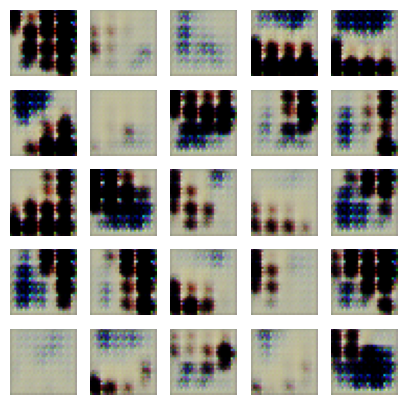

Epoch 11/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.407, gen_loss=3.51]


Epoch 11/300 - Gen Loss: 3.5103, Disc Loss: 0.4070


Epoch 12/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.337, gen_loss=3.91]


Epoch 12/300 - Gen Loss: 3.9085, Disc Loss: 0.3371


Epoch 13/300: 100%|██████████| 196/196 [00:14<00:00, 13.17batch/s, disc_loss=0.442, gen_loss=3.06]


Epoch 13/300 - Gen Loss: 3.0588, Disc Loss: 0.4421


Epoch 14/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.32, gen_loss=3.54] 


Epoch 14/300 - Gen Loss: 3.5376, Disc Loss: 0.3204


Epoch 15/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.451, gen_loss=3.57]


Epoch 15/300 - Gen Loss: 3.5714, Disc Loss: 0.4508


Epoch 16/300: 100%|██████████| 196/196 [00:14<00:00, 13.15batch/s, disc_loss=0.354, gen_loss=4.11]


Epoch 16/300 - Gen Loss: 4.1125, Disc Loss: 0.3542


Epoch 17/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.436, gen_loss=3.33]


Epoch 17/300 - Gen Loss: 3.3335, Disc Loss: 0.4365


Epoch 18/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.418, gen_loss=3.53]


Epoch 18/300 - Gen Loss: 3.5313, Disc Loss: 0.4183


Epoch 19/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.415, gen_loss=3.2] 


Epoch 19/300 - Gen Loss: 3.1977, Disc Loss: 0.4147


Epoch 20/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=0.38, gen_loss=3.52] 


Epoch 20/300 - Gen Loss: 3.5196, Disc Loss: 0.3800


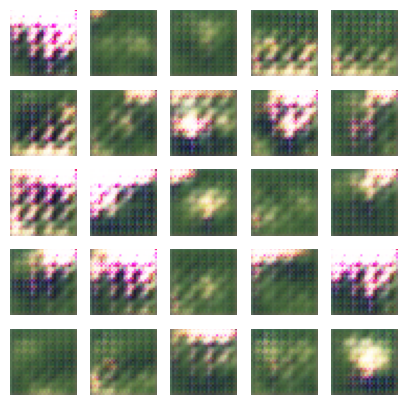

Epoch 21/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.422, gen_loss=3.47]


Epoch 21/300 - Gen Loss: 3.4662, Disc Loss: 0.4217


Epoch 22/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.276, gen_loss=3.71]


Epoch 22/300 - Gen Loss: 3.7125, Disc Loss: 0.2759


Epoch 23/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.366, gen_loss=3.68]


Epoch 23/300 - Gen Loss: 3.6806, Disc Loss: 0.3655


Epoch 24/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.393, gen_loss=3.56]


Epoch 24/300 - Gen Loss: 3.5589, Disc Loss: 0.3935


Epoch 25/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=0.34, gen_loss=3.51] 


Epoch 25/300 - Gen Loss: 3.5052, Disc Loss: 0.3399


Epoch 26/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.334, gen_loss=3.67]


Epoch 26/300 - Gen Loss: 3.6676, Disc Loss: 0.3337


Epoch 27/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.388, gen_loss=3.17]


Epoch 27/300 - Gen Loss: 3.1709, Disc Loss: 0.3878


Epoch 28/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=0.421, gen_loss=3.38]


Epoch 28/300 - Gen Loss: 3.3814, Disc Loss: 0.4214


Epoch 29/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=0.321, gen_loss=3.84]


Epoch 29/300 - Gen Loss: 3.8388, Disc Loss: 0.3208


Epoch 30/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.286, gen_loss=4.47]


Epoch 30/300 - Gen Loss: 4.4654, Disc Loss: 0.2859


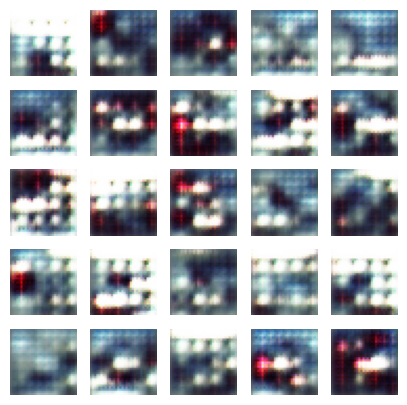

Epoch 31/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.284, gen_loss=4.3] 


Epoch 31/300 - Gen Loss: 4.2994, Disc Loss: 0.2836


Epoch 32/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=0.287, gen_loss=3.97]


Epoch 32/300 - Gen Loss: 3.9651, Disc Loss: 0.2867


Epoch 33/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.304, gen_loss=4.09]


Epoch 33/300 - Gen Loss: 4.0909, Disc Loss: 0.3042


Epoch 34/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.346, gen_loss=4.06]


Epoch 34/300 - Gen Loss: 4.0646, Disc Loss: 0.3463


Epoch 35/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.363, gen_loss=4.03]


Epoch 35/300 - Gen Loss: 4.0277, Disc Loss: 0.3634


Epoch 36/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=0.284, gen_loss=3.92]


Epoch 36/300 - Gen Loss: 3.9203, Disc Loss: 0.2841


Epoch 37/300: 100%|██████████| 196/196 [00:14<00:00, 13.18batch/s, disc_loss=0.434, gen_loss=3.63]


Epoch 37/300 - Gen Loss: 3.6283, Disc Loss: 0.4342


Epoch 38/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.33, gen_loss=3.98] 


Epoch 38/300 - Gen Loss: 3.9796, Disc Loss: 0.3296


Epoch 39/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.364, gen_loss=3.9] 


Epoch 39/300 - Gen Loss: 3.8978, Disc Loss: 0.3640


Epoch 40/300: 100%|██████████| 196/196 [00:15<00:00, 13.02batch/s, disc_loss=0.429, gen_loss=3.77]


Epoch 40/300 - Gen Loss: 3.7652, Disc Loss: 0.4288


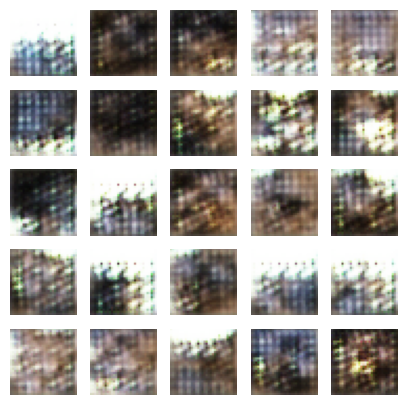

Epoch 41/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.395, gen_loss=3.55]


Epoch 41/300 - Gen Loss: 3.5513, Disc Loss: 0.3950


Epoch 42/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.392, gen_loss=3.92]


Epoch 42/300 - Gen Loss: 3.9228, Disc Loss: 0.3918


Epoch 43/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.364, gen_loss=4.28]


Epoch 43/300 - Gen Loss: 4.2811, Disc Loss: 0.3637


Epoch 44/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.358, gen_loss=3.96]


Epoch 44/300 - Gen Loss: 3.9608, Disc Loss: 0.3584


Epoch 45/300: 100%|██████████| 196/196 [00:15<00:00, 12.97batch/s, disc_loss=0.352, gen_loss=3.8] 


Epoch 45/300 - Gen Loss: 3.8050, Disc Loss: 0.3517


Epoch 46/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.383, gen_loss=3.7] 


Epoch 46/300 - Gen Loss: 3.7031, Disc Loss: 0.3829


Epoch 47/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.48, gen_loss=3.35] 


Epoch 47/300 - Gen Loss: 3.3546, Disc Loss: 0.4797


Epoch 48/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.517, gen_loss=3.42]


Epoch 48/300 - Gen Loss: 3.4249, Disc Loss: 0.5167


Epoch 49/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.587, gen_loss=2.95]


Epoch 49/300 - Gen Loss: 2.9461, Disc Loss: 0.5871


Epoch 50/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=0.451, gen_loss=3.3] 


Epoch 50/300 - Gen Loss: 3.3025, Disc Loss: 0.4512


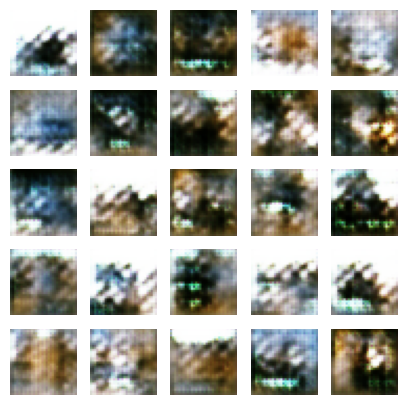

Epoch 51/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.432, gen_loss=4.01]


Epoch 51/300 - Gen Loss: 4.0147, Disc Loss: 0.4317


Epoch 52/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.527, gen_loss=3.32]


Epoch 52/300 - Gen Loss: 3.3177, Disc Loss: 0.5274


Epoch 53/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=0.449, gen_loss=3.2] 


Epoch 53/300 - Gen Loss: 3.1953, Disc Loss: 0.4488


Epoch 54/300: 100%|██████████| 196/196 [00:15<00:00, 12.97batch/s, disc_loss=0.51, gen_loss=3.35] 


Epoch 54/300 - Gen Loss: 3.3471, Disc Loss: 0.5099


Epoch 55/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.606, gen_loss=3.22]


Epoch 55/300 - Gen Loss: 3.2232, Disc Loss: 0.6063


Epoch 56/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.476, gen_loss=3.3] 


Epoch 56/300 - Gen Loss: 3.3022, Disc Loss: 0.4757


Epoch 57/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.524, gen_loss=3.12]


Epoch 57/300 - Gen Loss: 3.1239, Disc Loss: 0.5243


Epoch 58/300: 100%|██████████| 196/196 [00:15<00:00, 12.94batch/s, disc_loss=0.556, gen_loss=2.94]


Epoch 58/300 - Gen Loss: 2.9398, Disc Loss: 0.5563


Epoch 59/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.558, gen_loss=3.25]


Epoch 59/300 - Gen Loss: 3.2523, Disc Loss: 0.5579


Epoch 60/300: 100%|██████████| 196/196 [00:15<00:00, 12.96batch/s, disc_loss=0.555, gen_loss=3.45]


Epoch 60/300 - Gen Loss: 3.4479, Disc Loss: 0.5552


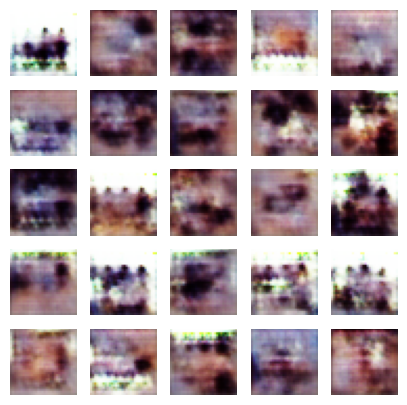

Epoch 61/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.63, gen_loss=3.65] 


Epoch 61/300 - Gen Loss: 3.6520, Disc Loss: 0.6301


Epoch 62/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.575, gen_loss=2.51]


Epoch 62/300 - Gen Loss: 2.5146, Disc Loss: 0.5750


Epoch 63/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.552, gen_loss=2.83]


Epoch 63/300 - Gen Loss: 2.8306, Disc Loss: 0.5522


Epoch 64/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.492, gen_loss=3.42]


Epoch 64/300 - Gen Loss: 3.4196, Disc Loss: 0.4921


Epoch 65/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.602, gen_loss=3.17]


Epoch 65/300 - Gen Loss: 3.1676, Disc Loss: 0.6019


Epoch 66/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.531, gen_loss=3.18]


Epoch 66/300 - Gen Loss: 3.1753, Disc Loss: 0.5306


Epoch 67/300: 100%|██████████| 196/196 [00:15<00:00, 12.95batch/s, disc_loss=0.612, gen_loss=2.9] 


Epoch 67/300 - Gen Loss: 2.8972, Disc Loss: 0.6118


Epoch 68/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=0.589, gen_loss=2.89]


Epoch 68/300 - Gen Loss: 2.8909, Disc Loss: 0.5893


Epoch 69/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.552, gen_loss=2.99]


Epoch 69/300 - Gen Loss: 2.9861, Disc Loss: 0.5517


Epoch 70/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.669, gen_loss=2.83]


Epoch 70/300 - Gen Loss: 2.8271, Disc Loss: 0.6694


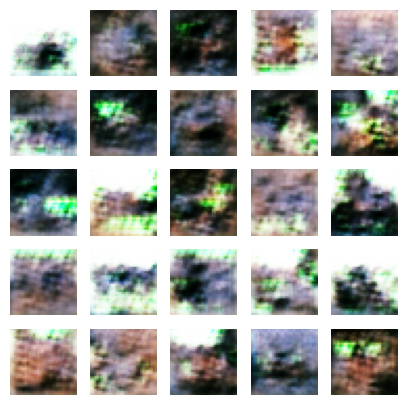

Epoch 71/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.53, gen_loss=2.76] 


Epoch 71/300 - Gen Loss: 2.7643, Disc Loss: 0.5300


Epoch 72/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.692, gen_loss=2.55]


Epoch 72/300 - Gen Loss: 2.5481, Disc Loss: 0.6919


Epoch 73/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.606, gen_loss=2.88]


Epoch 73/300 - Gen Loss: 2.8774, Disc Loss: 0.6058


Epoch 74/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.655, gen_loss=2.98]


Epoch 74/300 - Gen Loss: 2.9767, Disc Loss: 0.6548


Epoch 75/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.576, gen_loss=3.2] 


Epoch 75/300 - Gen Loss: 3.1999, Disc Loss: 0.5762


Epoch 76/300: 100%|██████████| 196/196 [00:15<00:00, 12.99batch/s, disc_loss=0.523, gen_loss=3.14]


Epoch 76/300 - Gen Loss: 3.1365, Disc Loss: 0.5227


Epoch 77/300: 100%|██████████| 196/196 [00:15<00:00, 13.07batch/s, disc_loss=0.589, gen_loss=2.79]


Epoch 77/300 - Gen Loss: 2.7894, Disc Loss: 0.5889


Epoch 78/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.621, gen_loss=2.79]


Epoch 78/300 - Gen Loss: 2.7941, Disc Loss: 0.6209


Epoch 79/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.691, gen_loss=2.91]


Epoch 79/300 - Gen Loss: 2.9145, Disc Loss: 0.6908


Epoch 80/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.579, gen_loss=2.86]


Epoch 80/300 - Gen Loss: 2.8644, Disc Loss: 0.5785


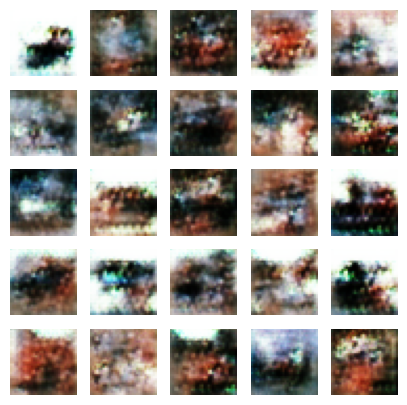

Epoch 81/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.685, gen_loss=2.58]


Epoch 81/300 - Gen Loss: 2.5822, Disc Loss: 0.6850


Epoch 82/300: 100%|██████████| 196/196 [00:15<00:00, 13.02batch/s, disc_loss=0.6, gen_loss=2.81]  


Epoch 82/300 - Gen Loss: 2.8140, Disc Loss: 0.5999


Epoch 83/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.609, gen_loss=2.74]


Epoch 83/300 - Gen Loss: 2.7403, Disc Loss: 0.6093


Epoch 84/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.629, gen_loss=2.61]


Epoch 84/300 - Gen Loss: 2.6125, Disc Loss: 0.6291


Epoch 85/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.687, gen_loss=2.88]


Epoch 85/300 - Gen Loss: 2.8761, Disc Loss: 0.6866


Epoch 86/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=0.617, gen_loss=2.85]


Epoch 86/300 - Gen Loss: 2.8452, Disc Loss: 0.6173


Epoch 87/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.664, gen_loss=2.72]


Epoch 87/300 - Gen Loss: 2.7244, Disc Loss: 0.6637


Epoch 88/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.547, gen_loss=2.77]


Epoch 88/300 - Gen Loss: 2.7719, Disc Loss: 0.5474


Epoch 89/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=0.642, gen_loss=2.96]


Epoch 89/300 - Gen Loss: 2.9640, Disc Loss: 0.6421


Epoch 90/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.668, gen_loss=2.58]


Epoch 90/300 - Gen Loss: 2.5847, Disc Loss: 0.6682


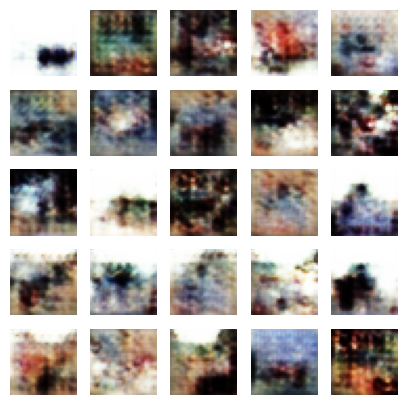

Epoch 91/300: 100%|██████████| 196/196 [00:14<00:00, 13.17batch/s, disc_loss=0.612, gen_loss=2.88]


Epoch 91/300 - Gen Loss: 2.8768, Disc Loss: 0.6117


Epoch 92/300: 100%|██████████| 196/196 [00:14<00:00, 13.15batch/s, disc_loss=0.571, gen_loss=2.88]


Epoch 92/300 - Gen Loss: 2.8827, Disc Loss: 0.5713


Epoch 93/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=0.574, gen_loss=2.77]


Epoch 93/300 - Gen Loss: 2.7691, Disc Loss: 0.5742


Epoch 94/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=0.68, gen_loss=2.66] 


Epoch 94/300 - Gen Loss: 2.6570, Disc Loss: 0.6798


Epoch 95/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.696, gen_loss=2.61]


Epoch 95/300 - Gen Loss: 2.6094, Disc Loss: 0.6960


Epoch 96/300: 100%|██████████| 196/196 [00:14<00:00, 13.17batch/s, disc_loss=0.713, gen_loss=2.52]


Epoch 96/300 - Gen Loss: 2.5228, Disc Loss: 0.7127


Epoch 97/300: 100%|██████████| 196/196 [00:14<00:00, 13.15batch/s, disc_loss=0.694, gen_loss=2.6] 


Epoch 97/300 - Gen Loss: 2.5996, Disc Loss: 0.6940


Epoch 98/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.715, gen_loss=2.44]


Epoch 98/300 - Gen Loss: 2.4363, Disc Loss: 0.7153


Epoch 99/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=0.657, gen_loss=2.5] 


Epoch 99/300 - Gen Loss: 2.5031, Disc Loss: 0.6573


Epoch 100/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=0.76, gen_loss=2.4]  


Epoch 100/300 - Gen Loss: 2.4031, Disc Loss: 0.7603


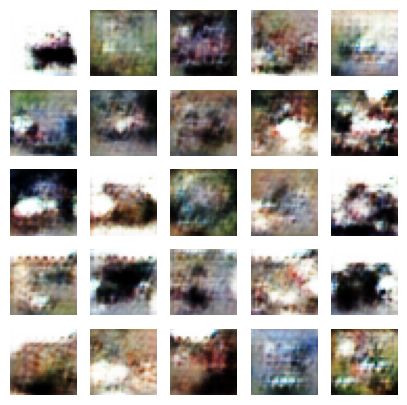

Epoch 101/300: 100%|██████████| 196/196 [00:14<00:00, 13.22batch/s, disc_loss=0.748, gen_loss=2.45]


Epoch 101/300 - Gen Loss: 2.4528, Disc Loss: 0.7481


Epoch 102/300: 100%|██████████| 196/196 [00:14<00:00, 13.20batch/s, disc_loss=0.726, gen_loss=2.44]


Epoch 102/300 - Gen Loss: 2.4428, Disc Loss: 0.7262


Epoch 103/300: 100%|██████████| 196/196 [00:14<00:00, 13.20batch/s, disc_loss=0.701, gen_loss=2.58]


Epoch 103/300 - Gen Loss: 2.5792, Disc Loss: 0.7013


Epoch 104/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.699, gen_loss=2.55]


Epoch 104/300 - Gen Loss: 2.5451, Disc Loss: 0.6990


Epoch 105/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.739, gen_loss=2.54]


Epoch 105/300 - Gen Loss: 2.5432, Disc Loss: 0.7391


Epoch 106/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.692, gen_loss=2.46]


Epoch 106/300 - Gen Loss: 2.4595, Disc Loss: 0.6917


Epoch 107/300: 100%|██████████| 196/196 [00:14<00:00, 13.18batch/s, disc_loss=0.875, gen_loss=2.08]


Epoch 107/300 - Gen Loss: 2.0843, Disc Loss: 0.8754


Epoch 108/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=0.725, gen_loss=2.41]


Epoch 108/300 - Gen Loss: 2.4107, Disc Loss: 0.7247


Epoch 109/300: 100%|██████████| 196/196 [00:14<00:00, 13.17batch/s, disc_loss=0.701, gen_loss=2.41]


Epoch 109/300 - Gen Loss: 2.4051, Disc Loss: 0.7008


Epoch 110/300: 100%|██████████| 196/196 [00:14<00:00, 13.21batch/s, disc_loss=0.801, gen_loss=2.31]


Epoch 110/300 - Gen Loss: 2.3094, Disc Loss: 0.8006


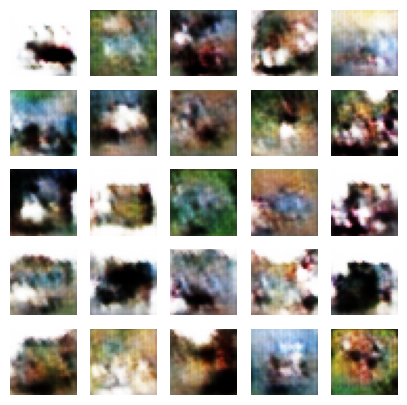

Epoch 111/300: 100%|██████████| 196/196 [00:14<00:00, 13.25batch/s, disc_loss=0.761, gen_loss=2.41]


Epoch 111/300 - Gen Loss: 2.4056, Disc Loss: 0.7613


Epoch 112/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=0.736, gen_loss=2.33]


Epoch 112/300 - Gen Loss: 2.3332, Disc Loss: 0.7355


Epoch 113/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.737, gen_loss=2.45]


Epoch 113/300 - Gen Loss: 2.4502, Disc Loss: 0.7368


Epoch 114/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=0.813, gen_loss=2.23]


Epoch 114/300 - Gen Loss: 2.2307, Disc Loss: 0.8134


Epoch 115/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=0.79, gen_loss=2.2]  


Epoch 115/300 - Gen Loss: 2.2023, Disc Loss: 0.7899


Epoch 116/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.744, gen_loss=2.41]


Epoch 116/300 - Gen Loss: 2.4111, Disc Loss: 0.7442


Epoch 117/300: 100%|██████████| 196/196 [00:14<00:00, 13.19batch/s, disc_loss=0.791, gen_loss=2.27]


Epoch 117/300 - Gen Loss: 2.2738, Disc Loss: 0.7905


Epoch 118/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=0.771, gen_loss=2.22]


Epoch 118/300 - Gen Loss: 2.2205, Disc Loss: 0.7710


Epoch 119/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.763, gen_loss=2.09]


Epoch 119/300 - Gen Loss: 2.0881, Disc Loss: 0.7626


Epoch 120/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.827, gen_loss=2.14]


Epoch 120/300 - Gen Loss: 2.1359, Disc Loss: 0.8265


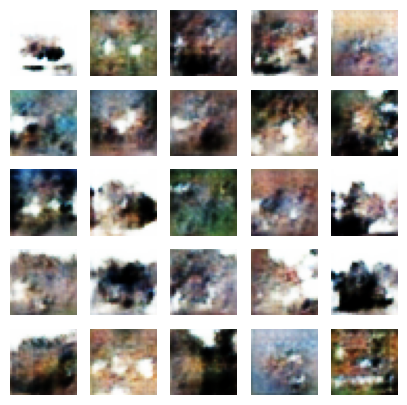

Epoch 121/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.858, gen_loss=2.08]


Epoch 121/300 - Gen Loss: 2.0776, Disc Loss: 0.8584


Epoch 122/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.824, gen_loss=2.08]


Epoch 122/300 - Gen Loss: 2.0809, Disc Loss: 0.8242


Epoch 123/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=0.758, gen_loss=2.18]


Epoch 123/300 - Gen Loss: 2.1781, Disc Loss: 0.7584


Epoch 124/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=0.812, gen_loss=2.25]


Epoch 124/300 - Gen Loss: 2.2491, Disc Loss: 0.8122


Epoch 125/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.803, gen_loss=2.11]


Epoch 125/300 - Gen Loss: 2.1145, Disc Loss: 0.8032


Epoch 126/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=0.838, gen_loss=2.14]


Epoch 126/300 - Gen Loss: 2.1442, Disc Loss: 0.8377


Epoch 127/300: 100%|██████████| 196/196 [00:14<00:00, 13.20batch/s, disc_loss=0.792, gen_loss=2.12]


Epoch 127/300 - Gen Loss: 2.1179, Disc Loss: 0.7922


Epoch 128/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.796, gen_loss=2.19]


Epoch 128/300 - Gen Loss: 2.1932, Disc Loss: 0.7956


Epoch 129/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.842, gen_loss=2.18]


Epoch 129/300 - Gen Loss: 2.1785, Disc Loss: 0.8424


Epoch 130/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.785, gen_loss=2.2] 


Epoch 130/300 - Gen Loss: 2.1957, Disc Loss: 0.7850


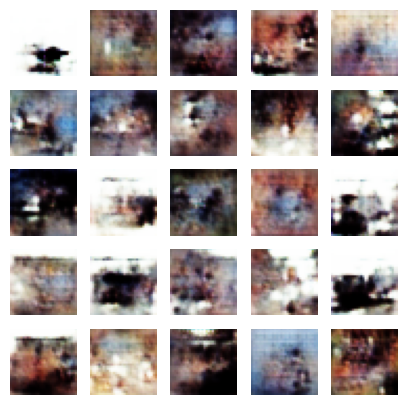

Epoch 131/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.796, gen_loss=2.05]


Epoch 131/300 - Gen Loss: 2.0456, Disc Loss: 0.7955


Epoch 132/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=0.808, gen_loss=2.02]


Epoch 132/300 - Gen Loss: 2.0173, Disc Loss: 0.8084


Epoch 133/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.883, gen_loss=1.95]


Epoch 133/300 - Gen Loss: 1.9529, Disc Loss: 0.8831


Epoch 134/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.816, gen_loss=2.03]


Epoch 134/300 - Gen Loss: 2.0314, Disc Loss: 0.8160


Epoch 135/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.843, gen_loss=2.12]


Epoch 135/300 - Gen Loss: 2.1157, Disc Loss: 0.8425


Epoch 136/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.836, gen_loss=2.17]


Epoch 136/300 - Gen Loss: 2.1676, Disc Loss: 0.8359


Epoch 137/300: 100%|██████████| 196/196 [00:15<00:00, 13.00batch/s, disc_loss=0.844, gen_loss=2.11]


Epoch 137/300 - Gen Loss: 2.1062, Disc Loss: 0.8443


Epoch 138/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.816, gen_loss=1.98]


Epoch 138/300 - Gen Loss: 1.9845, Disc Loss: 0.8165


Epoch 139/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.829, gen_loss=1.94]


Epoch 139/300 - Gen Loss: 1.9402, Disc Loss: 0.8286


Epoch 140/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=0.822, gen_loss=2.13]


Epoch 140/300 - Gen Loss: 2.1312, Disc Loss: 0.8216


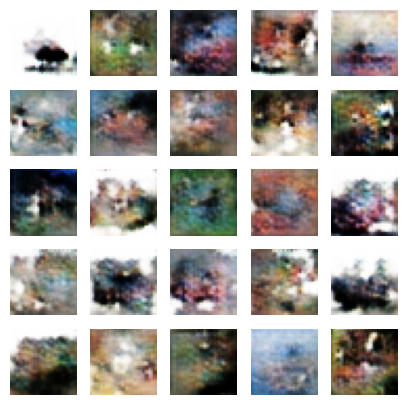

Epoch 141/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.882, gen_loss=1.85]


Epoch 141/300 - Gen Loss: 1.8501, Disc Loss: 0.8818


Epoch 142/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=0.865, gen_loss=2.1] 


Epoch 142/300 - Gen Loss: 2.0951, Disc Loss: 0.8651


Epoch 143/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.896, gen_loss=1.84]


Epoch 143/300 - Gen Loss: 1.8400, Disc Loss: 0.8963


Epoch 144/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=0.874, gen_loss=2.06]


Epoch 144/300 - Gen Loss: 2.0635, Disc Loss: 0.8744


Epoch 145/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.871, gen_loss=1.86]


Epoch 145/300 - Gen Loss: 1.8597, Disc Loss: 0.8712


Epoch 146/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.85, gen_loss=1.99] 


Epoch 146/300 - Gen Loss: 1.9870, Disc Loss: 0.8498


Epoch 147/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.846, gen_loss=1.98]


Epoch 147/300 - Gen Loss: 1.9824, Disc Loss: 0.8462


Epoch 148/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.834, gen_loss=1.97]


Epoch 148/300 - Gen Loss: 1.9680, Disc Loss: 0.8341


Epoch 149/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.813, gen_loss=1.99]


Epoch 149/300 - Gen Loss: 1.9912, Disc Loss: 0.8127


Epoch 150/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.844, gen_loss=1.91]


Epoch 150/300 - Gen Loss: 1.9125, Disc Loss: 0.8437


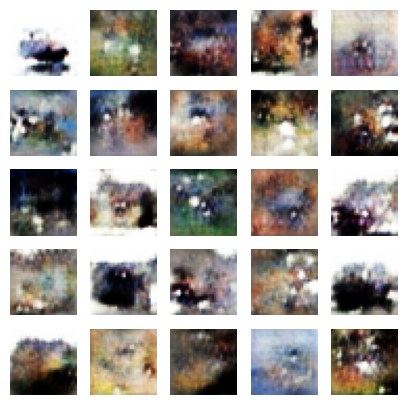

Epoch 151/300: 100%|██████████| 196/196 [00:14<00:00, 13.18batch/s, disc_loss=0.826, gen_loss=1.98]


Epoch 151/300 - Gen Loss: 1.9788, Disc Loss: 0.8256


Epoch 152/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=0.884, gen_loss=2.03]


Epoch 152/300 - Gen Loss: 2.0291, Disc Loss: 0.8839


Epoch 153/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=0.877, gen_loss=1.82]


Epoch 153/300 - Gen Loss: 1.8250, Disc Loss: 0.8770


Epoch 154/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.867, gen_loss=1.89]


Epoch 154/300 - Gen Loss: 1.8945, Disc Loss: 0.8667


Epoch 155/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.866, gen_loss=1.76]


Epoch 155/300 - Gen Loss: 1.7590, Disc Loss: 0.8658


Epoch 156/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.85, gen_loss=1.89] 


Epoch 156/300 - Gen Loss: 1.8853, Disc Loss: 0.8499


Epoch 157/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=0.923, gen_loss=1.75]


Epoch 157/300 - Gen Loss: 1.7540, Disc Loss: 0.9233


Epoch 158/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.885, gen_loss=1.78]


Epoch 158/300 - Gen Loss: 1.7819, Disc Loss: 0.8849


Epoch 159/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.905, gen_loss=1.85]


Epoch 159/300 - Gen Loss: 1.8537, Disc Loss: 0.9051


Epoch 160/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.783, gen_loss=2.08]


Epoch 160/300 - Gen Loss: 2.0808, Disc Loss: 0.7830


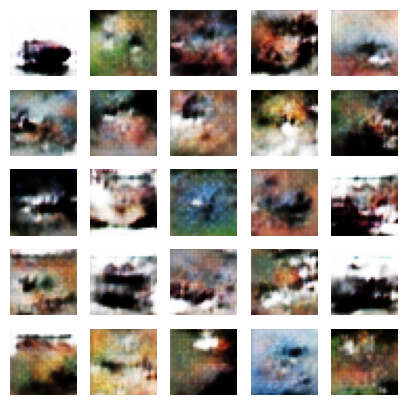

Epoch 161/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=0.872, gen_loss=1.89]


Epoch 161/300 - Gen Loss: 1.8915, Disc Loss: 0.8715


Epoch 162/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=0.883, gen_loss=1.91]


Epoch 162/300 - Gen Loss: 1.9109, Disc Loss: 0.8827


Epoch 163/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.863, gen_loss=1.77]


Epoch 163/300 - Gen Loss: 1.7739, Disc Loss: 0.8628


Epoch 164/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.87, gen_loss=1.87] 


Epoch 164/300 - Gen Loss: 1.8695, Disc Loss: 0.8703


Epoch 165/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.849, gen_loss=1.76]


Epoch 165/300 - Gen Loss: 1.7564, Disc Loss: 0.8492


Epoch 166/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.861, gen_loss=1.8] 


Epoch 166/300 - Gen Loss: 1.8044, Disc Loss: 0.8611


Epoch 167/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.835, gen_loss=2.01]


Epoch 167/300 - Gen Loss: 2.0149, Disc Loss: 0.8353


Epoch 168/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.903, gen_loss=1.85]


Epoch 168/300 - Gen Loss: 1.8502, Disc Loss: 0.9029


Epoch 169/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=0.912, gen_loss=1.87]


Epoch 169/300 - Gen Loss: 1.8663, Disc Loss: 0.9120


Epoch 170/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=0.872, gen_loss=1.89]


Epoch 170/300 - Gen Loss: 1.8933, Disc Loss: 0.8725


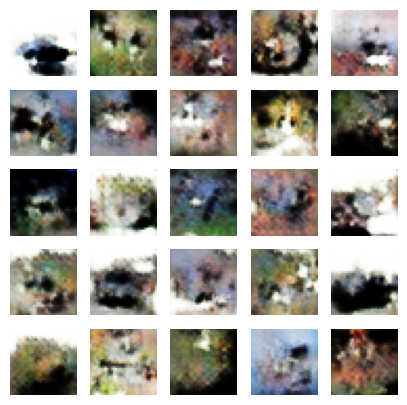

Epoch 171/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=0.859, gen_loss=1.79]


Epoch 171/300 - Gen Loss: 1.7930, Disc Loss: 0.8594


Epoch 172/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.78, gen_loss=1.98] 


Epoch 172/300 - Gen Loss: 1.9803, Disc Loss: 0.7802


Epoch 173/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=0.919, gen_loss=1.86]


Epoch 173/300 - Gen Loss: 1.8615, Disc Loss: 0.9187


Epoch 174/300: 100%|██████████| 196/196 [00:15<00:00, 13.02batch/s, disc_loss=0.886, gen_loss=1.78]


Epoch 174/300 - Gen Loss: 1.7845, Disc Loss: 0.8865


Epoch 175/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.873, gen_loss=1.74]


Epoch 175/300 - Gen Loss: 1.7425, Disc Loss: 0.8734


Epoch 176/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.831, gen_loss=1.78]


Epoch 176/300 - Gen Loss: 1.7798, Disc Loss: 0.8307


Epoch 177/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.895, gen_loss=1.74]


Epoch 177/300 - Gen Loss: 1.7384, Disc Loss: 0.8954


Epoch 178/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.92, gen_loss=1.81] 


Epoch 178/300 - Gen Loss: 1.8121, Disc Loss: 0.9196


Epoch 179/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.874, gen_loss=1.85]


Epoch 179/300 - Gen Loss: 1.8455, Disc Loss: 0.8744


Epoch 180/300: 100%|██████████| 196/196 [00:15<00:00, 13.00batch/s, disc_loss=0.859, gen_loss=1.81]


Epoch 180/300 - Gen Loss: 1.8104, Disc Loss: 0.8587


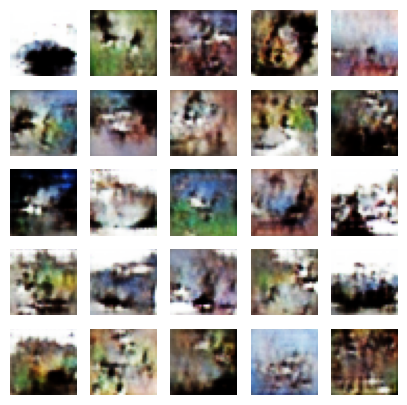

Epoch 181/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.829, gen_loss=1.92]


Epoch 181/300 - Gen Loss: 1.9204, Disc Loss: 0.8295


Epoch 182/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.831, gen_loss=2.01]


Epoch 182/300 - Gen Loss: 2.0147, Disc Loss: 0.8315


Epoch 183/300: 100%|██████████| 196/196 [00:15<00:00, 12.98batch/s, disc_loss=0.911, gen_loss=1.89]


Epoch 183/300 - Gen Loss: 1.8907, Disc Loss: 0.9109


Epoch 184/300: 100%|██████████| 196/196 [00:15<00:00, 12.99batch/s, disc_loss=0.785, gen_loss=1.99]


Epoch 184/300 - Gen Loss: 1.9865, Disc Loss: 0.7846


Epoch 185/300: 100%|██████████| 196/196 [00:15<00:00, 12.99batch/s, disc_loss=0.884, gen_loss=1.88]


Epoch 185/300 - Gen Loss: 1.8790, Disc Loss: 0.8837


Epoch 186/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.893, gen_loss=1.77]


Epoch 186/300 - Gen Loss: 1.7700, Disc Loss: 0.8928


Epoch 187/300: 100%|██████████| 196/196 [00:15<00:00, 12.99batch/s, disc_loss=0.882, gen_loss=1.76]


Epoch 187/300 - Gen Loss: 1.7632, Disc Loss: 0.8816


Epoch 188/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.857, gen_loss=1.7] 


Epoch 188/300 - Gen Loss: 1.6964, Disc Loss: 0.8568


Epoch 189/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.845, gen_loss=1.8] 


Epoch 189/300 - Gen Loss: 1.8010, Disc Loss: 0.8453


Epoch 190/300: 100%|██████████| 196/196 [00:15<00:00, 12.97batch/s, disc_loss=0.9, gen_loss=1.69]  


Epoch 190/300 - Gen Loss: 1.6891, Disc Loss: 0.9004


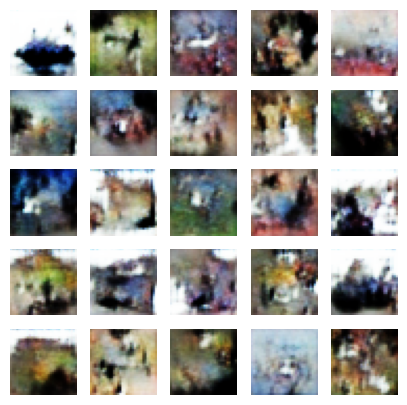

Epoch 191/300: 100%|██████████| 196/196 [00:14<00:00, 13.15batch/s, disc_loss=0.903, gen_loss=1.74]


Epoch 191/300 - Gen Loss: 1.7410, Disc Loss: 0.9029


Epoch 192/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=0.851, gen_loss=1.77]


Epoch 192/300 - Gen Loss: 1.7706, Disc Loss: 0.8515


Epoch 193/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=0.885, gen_loss=1.85]


Epoch 193/300 - Gen Loss: 1.8521, Disc Loss: 0.8854


Epoch 194/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.89, gen_loss=1.81] 


Epoch 194/300 - Gen Loss: 1.8101, Disc Loss: 0.8898


Epoch 195/300: 100%|██████████| 196/196 [00:15<00:00, 12.99batch/s, disc_loss=0.933, gen_loss=1.68]


Epoch 195/300 - Gen Loss: 1.6822, Disc Loss: 0.9331


Epoch 196/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.92, gen_loss=1.64] 


Epoch 196/300 - Gen Loss: 1.6431, Disc Loss: 0.9201


Epoch 197/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.863, gen_loss=1.74]


Epoch 197/300 - Gen Loss: 1.7427, Disc Loss: 0.8631


Epoch 198/300: 100%|██████████| 196/196 [00:15<00:00, 12.97batch/s, disc_loss=0.876, gen_loss=1.77]


Epoch 198/300 - Gen Loss: 1.7670, Disc Loss: 0.8761


Epoch 199/300: 100%|██████████| 196/196 [00:15<00:00, 13.07batch/s, disc_loss=0.901, gen_loss=1.74]


Epoch 199/300 - Gen Loss: 1.7435, Disc Loss: 0.9008


Epoch 200/300: 100%|██████████| 196/196 [00:15<00:00, 12.95batch/s, disc_loss=0.877, gen_loss=1.8] 


Epoch 200/300 - Gen Loss: 1.8022, Disc Loss: 0.8775


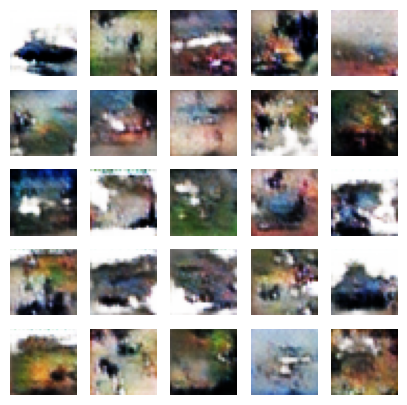

Epoch 201/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.877, gen_loss=1.77]


Epoch 201/300 - Gen Loss: 1.7702, Disc Loss: 0.8771


Epoch 202/300: 100%|██████████| 196/196 [00:15<00:00, 12.97batch/s, disc_loss=0.924, gen_loss=1.65]


Epoch 202/300 - Gen Loss: 1.6525, Disc Loss: 0.9244


Epoch 203/300: 100%|██████████| 196/196 [00:15<00:00, 12.98batch/s, disc_loss=0.929, gen_loss=1.62]


Epoch 203/300 - Gen Loss: 1.6238, Disc Loss: 0.9292


Epoch 204/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=0.937, gen_loss=1.64]


Epoch 204/300 - Gen Loss: 1.6371, Disc Loss: 0.9370


Epoch 205/300: 100%|██████████| 196/196 [00:15<00:00, 13.02batch/s, disc_loss=0.931, gen_loss=1.7] 


Epoch 205/300 - Gen Loss: 1.7020, Disc Loss: 0.9310


Epoch 206/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=0.878, gen_loss=1.84]


Epoch 206/300 - Gen Loss: 1.8356, Disc Loss: 0.8779


Epoch 207/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.89, gen_loss=1.8]  


Epoch 207/300 - Gen Loss: 1.8013, Disc Loss: 0.8904


Epoch 208/300: 100%|██████████| 196/196 [00:15<00:00, 13.00batch/s, disc_loss=0.959, gen_loss=1.67]


Epoch 208/300 - Gen Loss: 1.6696, Disc Loss: 0.9590


Epoch 209/300: 100%|██████████| 196/196 [00:15<00:00, 12.99batch/s, disc_loss=0.903, gen_loss=1.78]


Epoch 209/300 - Gen Loss: 1.7842, Disc Loss: 0.9029


Epoch 210/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.974, gen_loss=1.66]


Epoch 210/300 - Gen Loss: 1.6599, Disc Loss: 0.9741


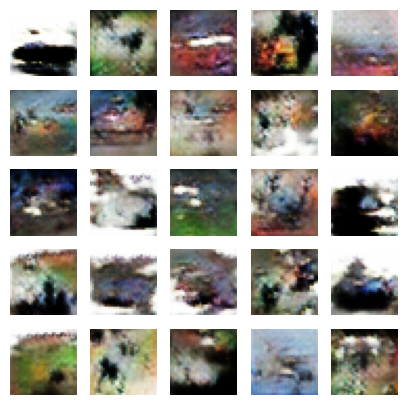

Epoch 211/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=0.978, gen_loss=1.51]


Epoch 211/300 - Gen Loss: 1.5066, Disc Loss: 0.9781


Epoch 212/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=0.927, gen_loss=1.56]


Epoch 212/300 - Gen Loss: 1.5633, Disc Loss: 0.9271


Epoch 213/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.968, gen_loss=1.51]


Epoch 213/300 - Gen Loss: 1.5064, Disc Loss: 0.9679


Epoch 214/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=0.928, gen_loss=1.61]


Epoch 214/300 - Gen Loss: 1.6123, Disc Loss: 0.9275


Epoch 215/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.968, gen_loss=1.62]


Epoch 215/300 - Gen Loss: 1.6234, Disc Loss: 0.9676


Epoch 216/300: 100%|██████████| 196/196 [00:15<00:00, 12.97batch/s, disc_loss=0.992, gen_loss=1.57]


Epoch 216/300 - Gen Loss: 1.5654, Disc Loss: 0.9919


Epoch 217/300: 100%|██████████| 196/196 [00:15<00:00, 12.99batch/s, disc_loss=0.965, gen_loss=1.47]


Epoch 217/300 - Gen Loss: 1.4694, Disc Loss: 0.9652


Epoch 218/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.98, gen_loss=1.5]  


Epoch 218/300 - Gen Loss: 1.5027, Disc Loss: 0.9802


Epoch 219/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=0.976, gen_loss=1.48]


Epoch 219/300 - Gen Loss: 1.4845, Disc Loss: 0.9761


Epoch 220/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=0.971, gen_loss=1.63]


Epoch 220/300 - Gen Loss: 1.6287, Disc Loss: 0.9713


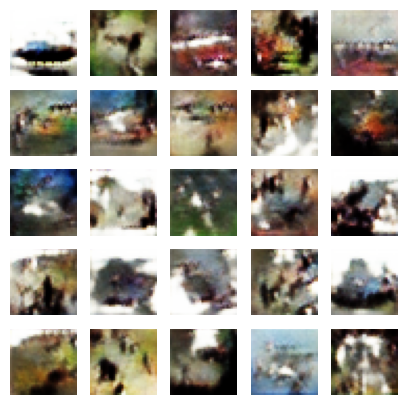

Epoch 221/300: 100%|██████████| 196/196 [00:15<00:00, 13.02batch/s, disc_loss=0.976, gen_loss=1.55]


Epoch 221/300 - Gen Loss: 1.5549, Disc Loss: 0.9756


Epoch 222/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=1.05, gen_loss=1.5] 


Epoch 222/300 - Gen Loss: 1.4962, Disc Loss: 1.0456


Epoch 223/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.931, gen_loss=1.6] 


Epoch 223/300 - Gen Loss: 1.6042, Disc Loss: 0.9309


Epoch 224/300: 100%|██████████| 196/196 [00:15<00:00, 13.02batch/s, disc_loss=0.991, gen_loss=1.53]


Epoch 224/300 - Gen Loss: 1.5264, Disc Loss: 0.9912


Epoch 225/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=0.914, gen_loss=1.66]


Epoch 225/300 - Gen Loss: 1.6559, Disc Loss: 0.9139


Epoch 226/300: 100%|██████████| 196/196 [00:15<00:00, 13.01batch/s, disc_loss=0.983, gen_loss=1.64]


Epoch 226/300 - Gen Loss: 1.6369, Disc Loss: 0.9825


Epoch 227/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=0.983, gen_loss=1.64]


Epoch 227/300 - Gen Loss: 1.6383, Disc Loss: 0.9834


Epoch 228/300: 100%|██████████| 196/196 [00:15<00:00, 13.04batch/s, disc_loss=1.09, gen_loss=1.36]


Epoch 228/300 - Gen Loss: 1.3629, Disc Loss: 1.0880


Epoch 229/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=1.01, gen_loss=1.41] 


Epoch 229/300 - Gen Loss: 1.4079, Disc Loss: 1.0120


Epoch 230/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=1.02, gen_loss=1.38] 


Epoch 230/300 - Gen Loss: 1.3843, Disc Loss: 1.0197


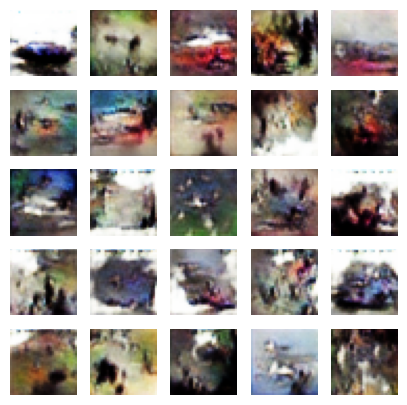

Epoch 231/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=1.01, gen_loss=1.38] 


Epoch 231/300 - Gen Loss: 1.3762, Disc Loss: 1.0078


Epoch 232/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=1.01, gen_loss=1.33]


Epoch 232/300 - Gen Loss: 1.3321, Disc Loss: 1.0150


Epoch 233/300: 100%|██████████| 196/196 [00:15<00:00, 13.05batch/s, disc_loss=1.04, gen_loss=1.38]


Epoch 233/300 - Gen Loss: 1.3842, Disc Loss: 1.0351


Epoch 234/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=1, gen_loss=1.51]   


Epoch 234/300 - Gen Loss: 1.5104, Disc Loss: 1.0005


Epoch 235/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=1.01, gen_loss=1.49]


Epoch 235/300 - Gen Loss: 1.4892, Disc Loss: 1.0124


Epoch 236/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=1.03, gen_loss=1.46]


Epoch 236/300 - Gen Loss: 1.4643, Disc Loss: 1.0307


Epoch 237/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=1.06, gen_loss=1.41]


Epoch 237/300 - Gen Loss: 1.4117, Disc Loss: 1.0647


Epoch 238/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=1.04, gen_loss=1.37] 


Epoch 238/300 - Gen Loss: 1.3660, Disc Loss: 1.0445


Epoch 239/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=0.949, gen_loss=1.44]


Epoch 239/300 - Gen Loss: 1.4394, Disc Loss: 0.9492


Epoch 240/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=1.08, gen_loss=1.37]


Epoch 240/300 - Gen Loss: 1.3659, Disc Loss: 1.0834


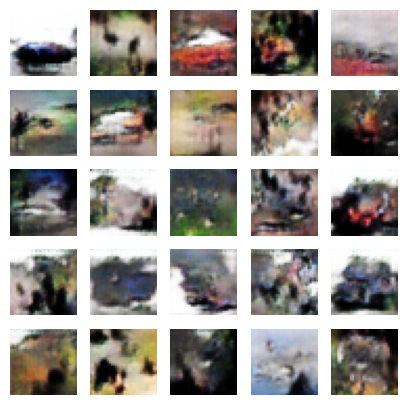

Epoch 241/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=0.999, gen_loss=1.5]


Epoch 241/300 - Gen Loss: 1.5039, Disc Loss: 0.9992


Epoch 242/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.12, gen_loss=1.28]


Epoch 242/300 - Gen Loss: 1.2803, Disc Loss: 1.1173


Epoch 243/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=1.03, gen_loss=1.31]


Epoch 243/300 - Gen Loss: 1.3058, Disc Loss: 1.0333


Epoch 244/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.08, gen_loss=1.29]


Epoch 244/300 - Gen Loss: 1.2859, Disc Loss: 1.0836


Epoch 245/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=1.12, gen_loss=1.28]


Epoch 245/300 - Gen Loss: 1.2752, Disc Loss: 1.1153


Epoch 246/300: 100%|██████████| 196/196 [00:14<00:00, 13.15batch/s, disc_loss=1.06, gen_loss=1.34]


Epoch 246/300 - Gen Loss: 1.3363, Disc Loss: 1.0556


Epoch 247/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=1.03, gen_loss=1.38]


Epoch 247/300 - Gen Loss: 1.3754, Disc Loss: 1.0283


Epoch 248/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=1.09, gen_loss=1.31]


Epoch 248/300 - Gen Loss: 1.3121, Disc Loss: 1.0867


Epoch 249/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=1.12, gen_loss=1.26]


Epoch 249/300 - Gen Loss: 1.2596, Disc Loss: 1.1215


Epoch 250/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=1.09, gen_loss=1.31]


Epoch 250/300 - Gen Loss: 1.3134, Disc Loss: 1.0895


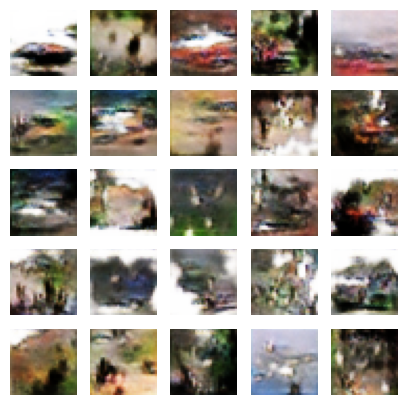

Epoch 251/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=1.11, gen_loss=1.21]


Epoch 251/300 - Gen Loss: 1.2094, Disc Loss: 1.1131


Epoch 252/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=1.08, gen_loss=1.26]


Epoch 252/300 - Gen Loss: 1.2624, Disc Loss: 1.0784


Epoch 253/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=1.07, gen_loss=1.33]


Epoch 253/300 - Gen Loss: 1.3287, Disc Loss: 1.0663


Epoch 254/300: 100%|██████████| 196/196 [00:14<00:00, 13.07batch/s, disc_loss=1.15, gen_loss=1.26]


Epoch 254/300 - Gen Loss: 1.2627, Disc Loss: 1.1499


Epoch 255/300: 100%|██████████| 196/196 [00:15<00:00, 12.99batch/s, disc_loss=1.07, gen_loss=1.26]


Epoch 255/300 - Gen Loss: 1.2594, Disc Loss: 1.0651


Epoch 256/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=1.1, gen_loss=1.25] 


Epoch 256/300 - Gen Loss: 1.2478, Disc Loss: 1.0963


Epoch 257/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.1, gen_loss=1.22] 


Epoch 257/300 - Gen Loss: 1.2207, Disc Loss: 1.1012


Epoch 258/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.14, gen_loss=1.18]


Epoch 258/300 - Gen Loss: 1.1836, Disc Loss: 1.1351


Epoch 259/300: 100%|██████████| 196/196 [00:15<00:00, 13.03batch/s, disc_loss=1.09, gen_loss=1.25]


Epoch 259/300 - Gen Loss: 1.2522, Disc Loss: 1.0903


Epoch 260/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=1.1, gen_loss=1.22] 


Epoch 260/300 - Gen Loss: 1.2167, Disc Loss: 1.1034


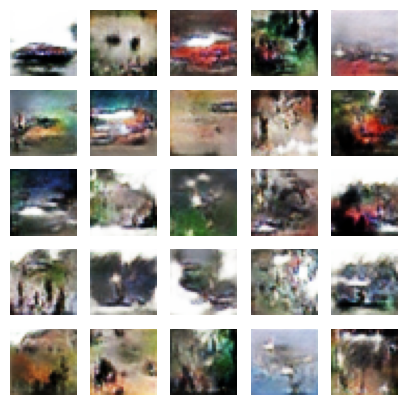

Epoch 261/300: 100%|██████████| 196/196 [00:14<00:00, 13.21batch/s, disc_loss=1.1, gen_loss=1.31] 


Epoch 261/300 - Gen Loss: 1.3071, Disc Loss: 1.1028


Epoch 262/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=1.13, gen_loss=1.3] 


Epoch 262/300 - Gen Loss: 1.2984, Disc Loss: 1.1273


Epoch 263/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=1.15, gen_loss=1.25]


Epoch 263/300 - Gen Loss: 1.2549, Disc Loss: 1.1523


Epoch 264/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=1.07, gen_loss=1.27]


Epoch 264/300 - Gen Loss: 1.2712, Disc Loss: 1.0659


Epoch 265/300: 100%|██████████| 196/196 [00:14<00:00, 13.18batch/s, disc_loss=1.11, gen_loss=1.21]


Epoch 265/300 - Gen Loss: 1.2076, Disc Loss: 1.1065


Epoch 266/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.12, gen_loss=1.24]


Epoch 266/300 - Gen Loss: 1.2355, Disc Loss: 1.1202


Epoch 267/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=1.1, gen_loss=1.22] 


Epoch 267/300 - Gen Loss: 1.2176, Disc Loss: 1.1025


Epoch 268/300: 100%|██████████| 196/196 [00:14<00:00, 13.17batch/s, disc_loss=1.09, gen_loss=1.28]


Epoch 268/300 - Gen Loss: 1.2833, Disc Loss: 1.0891


Epoch 269/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=1.16, gen_loss=1.24]


Epoch 269/300 - Gen Loss: 1.2428, Disc Loss: 1.1581


Epoch 270/300: 100%|██████████| 196/196 [00:14<00:00, 13.17batch/s, disc_loss=1.08, gen_loss=1.24]


Epoch 270/300 - Gen Loss: 1.2421, Disc Loss: 1.0827


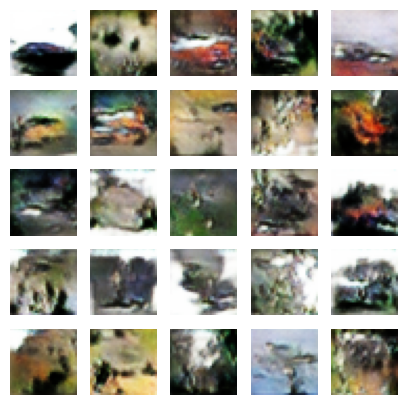

Epoch 271/300: 100%|██████████| 196/196 [00:14<00:00, 13.20batch/s, disc_loss=1.15, gen_loss=1.23]


Epoch 271/300 - Gen Loss: 1.2276, Disc Loss: 1.1496


Epoch 272/300: 100%|██████████| 196/196 [00:14<00:00, 13.20batch/s, disc_loss=1.1, gen_loss=1.18] 


Epoch 272/300 - Gen Loss: 1.1807, Disc Loss: 1.1049


Epoch 273/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=1.12, gen_loss=1.17]


Epoch 273/300 - Gen Loss: 1.1746, Disc Loss: 1.1190


Epoch 274/300: 100%|██████████| 196/196 [00:14<00:00, 13.11batch/s, disc_loss=1.13, gen_loss=1.16]


Epoch 274/300 - Gen Loss: 1.1590, Disc Loss: 1.1345


Epoch 275/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.12, gen_loss=1.16]


Epoch 275/300 - Gen Loss: 1.1552, Disc Loss: 1.1152


Epoch 276/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.13, gen_loss=1.19]


Epoch 276/300 - Gen Loss: 1.1928, Disc Loss: 1.1312


Epoch 277/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=1.14, gen_loss=1.18]


Epoch 277/300 - Gen Loss: 1.1839, Disc Loss: 1.1450


Epoch 278/300: 100%|██████████| 196/196 [00:14<00:00, 13.20batch/s, disc_loss=1.2, gen_loss=1.14] 


Epoch 278/300 - Gen Loss: 1.1397, Disc Loss: 1.2030


Epoch 279/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=1.09, gen_loss=1.22]


Epoch 279/300 - Gen Loss: 1.2175, Disc Loss: 1.0872


Epoch 280/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.13, gen_loss=1.25]


Epoch 280/300 - Gen Loss: 1.2479, Disc Loss: 1.1274


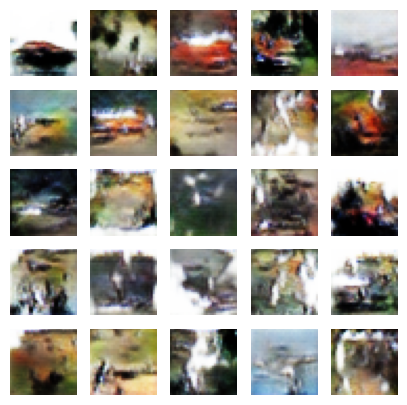

Epoch 281/300: 100%|██████████| 196/196 [00:14<00:00, 13.15batch/s, disc_loss=1.21, gen_loss=1.16]


Epoch 281/300 - Gen Loss: 1.1629, Disc Loss: 1.2136


Epoch 282/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=1.12, gen_loss=1.18]


Epoch 282/300 - Gen Loss: 1.1840, Disc Loss: 1.1152


Epoch 283/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=1.13, gen_loss=1.15]


Epoch 283/300 - Gen Loss: 1.1463, Disc Loss: 1.1280


Epoch 284/300: 100%|██████████| 196/196 [00:14<00:00, 13.17batch/s, disc_loss=1.14, gen_loss=1.17]


Epoch 284/300 - Gen Loss: 1.1712, Disc Loss: 1.1401


Epoch 285/300: 100%|██████████| 196/196 [00:14<00:00, 13.17batch/s, disc_loss=1.16, gen_loss=1.16]


Epoch 285/300 - Gen Loss: 1.1597, Disc Loss: 1.1563


Epoch 286/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.09, gen_loss=1.19]


Epoch 286/300 - Gen Loss: 1.1886, Disc Loss: 1.0948


Epoch 287/300: 100%|██████████| 196/196 [00:15<00:00, 13.06batch/s, disc_loss=1.1, gen_loss=1.37] 


Epoch 287/300 - Gen Loss: 1.3669, Disc Loss: 1.1025


Epoch 288/300: 100%|██████████| 196/196 [00:14<00:00, 13.18batch/s, disc_loss=1.16, gen_loss=1.17]


Epoch 288/300 - Gen Loss: 1.1700, Disc Loss: 1.1572


Epoch 289/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.17, gen_loss=1.13]


Epoch 289/300 - Gen Loss: 1.1299, Disc Loss: 1.1694


Epoch 290/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=1.13, gen_loss=1.14]


Epoch 290/300 - Gen Loss: 1.1430, Disc Loss: 1.1298


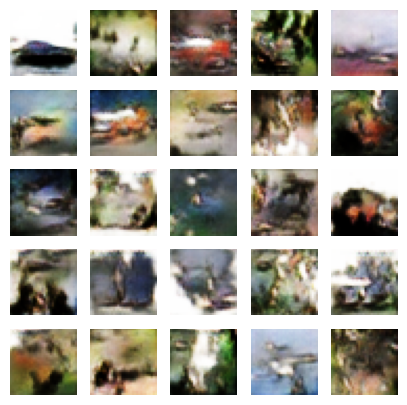

Epoch 291/300: 100%|██████████| 196/196 [00:14<00:00, 13.15batch/s, disc_loss=1.16, gen_loss=1.17]


Epoch 291/300 - Gen Loss: 1.1702, Disc Loss: 1.1581


Epoch 292/300: 100%|██████████| 196/196 [00:14<00:00, 13.16batch/s, disc_loss=1.1, gen_loss=1.16] 


Epoch 292/300 - Gen Loss: 1.1597, Disc Loss: 1.0996


Epoch 293/300: 100%|██████████| 196/196 [00:14<00:00, 13.14batch/s, disc_loss=1.12, gen_loss=1.21]


Epoch 293/300 - Gen Loss: 1.2149, Disc Loss: 1.1231


Epoch 294/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=1.09, gen_loss=1.29]


Epoch 294/300 - Gen Loss: 1.2857, Disc Loss: 1.0913


Epoch 295/300: 100%|██████████| 196/196 [00:14<00:00, 13.10batch/s, disc_loss=1.14, gen_loss=1.3] 


Epoch 295/300 - Gen Loss: 1.3038, Disc Loss: 1.1360


Epoch 296/300: 100%|██████████| 196/196 [00:14<00:00, 13.13batch/s, disc_loss=1.1, gen_loss=1.23] 


Epoch 296/300 - Gen Loss: 1.2277, Disc Loss: 1.1048


Epoch 297/300: 100%|██████████| 196/196 [00:14<00:00, 13.12batch/s, disc_loss=1.21, gen_loss=1.2] 


Epoch 297/300 - Gen Loss: 1.2023, Disc Loss: 1.2050


Epoch 298/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=1.1, gen_loss=1.19] 


Epoch 298/300 - Gen Loss: 1.1861, Disc Loss: 1.1024


Epoch 299/300: 100%|██████████| 196/196 [00:14<00:00, 13.09batch/s, disc_loss=1.12, gen_loss=1.28]


Epoch 299/300 - Gen Loss: 1.2765, Disc Loss: 1.1151


Epoch 300/300: 100%|██████████| 196/196 [00:14<00:00, 13.08batch/s, disc_loss=1.16, gen_loss=1.15]


Epoch 300/300 - Gen Loss: 1.1490, Disc Loss: 1.1557


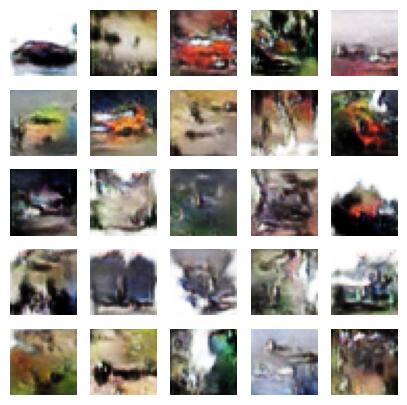

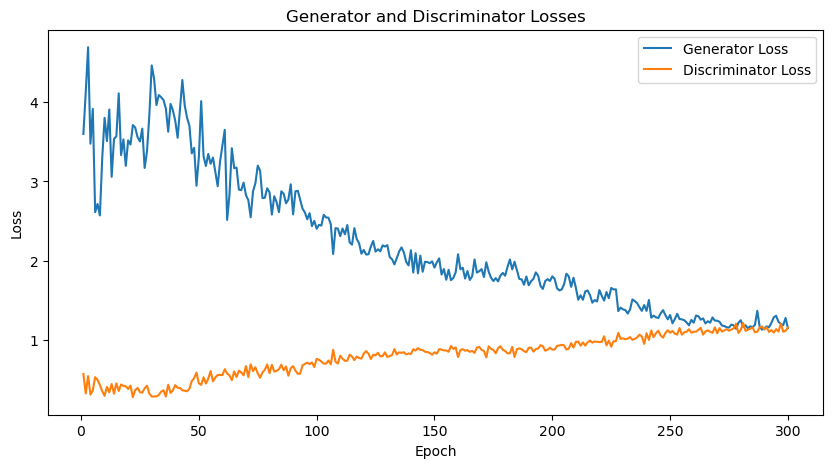

In [10]:
def train(dataset, epochs):
    run_folder = './Output'
    run_path = os.path.join(run_folder)
    os.makedirs(run_path, exist_ok=True)
    
    saveImages_path = os.path.join(run_path, 'SavedImages')
    os.makedirs(saveImages_path, exist_ok=True)

    seed = tf.random.normal([25, 100])  # Random noise for image generation
    gen_losses, disc_losses = [], []
    
    # Start training loop
    for epoch in range(epochs):
        total_gen_loss = 0.0
        total_disc_loss = 0.0
        with tqdm(dataset, desc=f'Epoch {epoch+1}/{epochs}', unit='batch', colour='green') as pbar:
            for image_batch in pbar:
                gen_loss, disc_loss = train_step(image_batch)  # Update losses during each step
                total_gen_loss += gen_loss
                total_disc_loss += disc_loss
                pbar.set_postfix(gen_loss=total_gen_loss.numpy() / (pbar.n + 1), 
                                 disc_loss=total_disc_loss.numpy() / (pbar.n + 1))
        
        # Append the average losses for the epoch
        gen_losses.append(total_gen_loss.numpy() / len(dataset))
        disc_losses.append(total_disc_loss.numpy() / len(dataset))
        
        # Print the losses for the epoch
        print(f"Epoch {epoch+1}/{epochs} - Gen Loss: {gen_losses[-1]:.4f}, Disc Loss: {disc_losses[-1]:.4f}")
        
        # Generate and save images every 10 epochs or at the final epoch
        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            saveImages(generator, epoch + 1, seed, saveImages_path)
    
    # Save the trained models
    os.makedirs(os.path.join(run_path, 'trainedModels'), exist_ok=True)
    generator.save(os.path.join(run_path, 'trainedModels/generator.h5'))
    discriminator.save(os.path.join(run_path, 'trainedModels/discriminator.h5'))
    
    # Save and plot the losses at the end of training
    loss_plot(gen_losses, disc_losses, epochs, run_path)

# Run the training
train(train_dataset, epochs=300)